In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/pietro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/pietro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pietro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pietro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
np.random.seed(500)

In [8]:
df = pd.read_csv(r"dataset_intent_train.csv",sep=';')
df

,question,scenario,intent
0,have i got any alarms set,alarm,query
1,what's the current temperature,weather,query
2,tell me about lisa ann,qa,factoid
3,play jumper by third eye blind,play,music
4,if there any alarm is set then let me know,alarm,query
...,...,...,...
14509,i want to mute the speaker,audio,volume_mute
14510,are there any alarms set what are they,alarm,query
14511,put on some techno music please,play,music
14512,kill all the frogs you see,general,quirky


In [9]:
# Step - a : Remove blank rows if any.
df['question'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
df['question'] = [entry.lower() for entry in df['question']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
df['question']= [word_tokenize(entry) for entry in df['question']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(df['question']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df.loc[index,'question_final'] = str(Final_words)

In [10]:
from io import StringIO
col = ['intent', 'question_final']
df = df[col]
df = df[pd.notnull(df['question_final'])]
df.columns = ['intent', 'question_final']
df['category_id'] = df['intent'].factorize()[0]
category_id_df = df[['intent', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'intent']].values)
df

,intent,question_final,category_id
0,query,"['get', 'alarm', 'set']",0
1,query,"['current', 'temperature']",0
2,factoid,"['tell', 'lisa', 'ann']",1
3,music,"['play', 'jumper', 'third', 'eye', 'blind']",2
4,query,"['alarm', 'set', 'let', 'know']",0
...,...,...,...
14509,volume_mute,"['want', 'mute', 'speaker']",28
14510,query,"['alarm', 'set']",0
14511,music,"['put', 'techno', 'music', 'please']",2
14512,quirky,"['kill', 'frog', 'see']",10


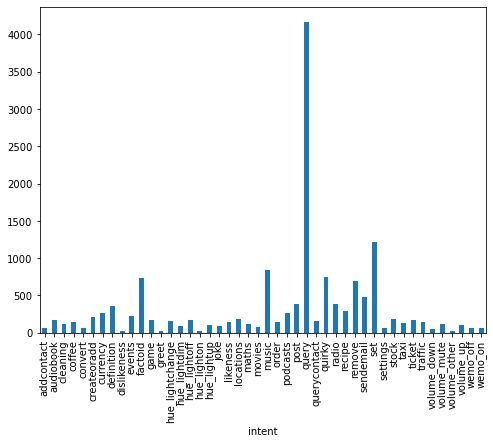

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('intent').question_final.count().plot.bar(ylim=0)
plt.show()

In [12]:
#SE NON FUNZIONA RIGUARDA QUESTA PARTE
#DEFAULT PARAMETERS 
#min_df = 5
#norm = '12'
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.question_final).toarray()
labels = df.category_id
features.shape

(14514, 6520)

In [13]:
from sklearn.feature_selection import chi2
N = 2
for intent, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(intent))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'addcontact':
  . Most correlated unigrams:
. add
. contact
  . Most correlated bigrams:
. email contact
. add email
# 'audiobook':
  . Most correlated unigrams:
. resume
. audiobook
  . Most correlated bigrams:
. play audiobook
. audio book
# 'cleaning':
  . Most correlated unigrams:
. cleaner
. vacuum
  . Most correlated bigrams:
. robot vacuum
. vacuum clean
# 'coffee':
  . Most correlated unigrams:
. machine
. coffee
  . Most correlated bigrams:
. coffee machine
. make coffee
# 'convert':
  . Most correlated unigrams:
. zone
. difference
  . Most correlated bigrams:
. change timezone
. time difference
# 'createoradd':
  . Most correlated unigrams:
. add
. list
  . Most correlated bigrams:
. grocery list
. new list
# 'currency':
  . Most correlated unigrams:
. rate
. dollar
  . Most correlated bigrams:
. dollar euro
. exchange rate
# 'definition':
  . Most correlated unigrams:
. definition
. define
  . Most correlated bigrams:
. look like
. definition word
# 'dislikeness':
  . Mos

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['question_final'], df['intent'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [15]:
#EXAMPLE OF PREDICTION 1
print(clf.predict(count_vect.transform(["delete item on list"])))

['remove']


In [16]:
#EXAMPLE OF PREDICTION 2
print(clf.predict(count_vect.transform(["what brand hair spray does donald trump use"])))

['query']


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

KeyboardInterrupt: 

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

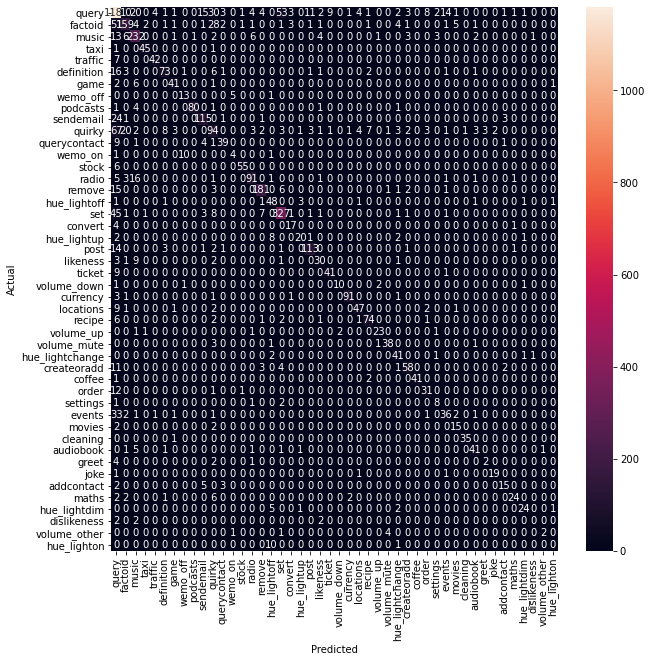

In [19]:
import seaborn as sns
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.intent.values, yticklabels=category_id_df.intent.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
from IPython.display import display
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            #display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['intent', 'question']])
            #print('')

'factoid' predicted as 'query' : 51 examples.
'music' predicted as 'query' : 13 examples.
'definition' predicted as 'query' : 16 examples.
'sendemail' predicted as 'query' : 24 examples.
'quirky' predicted as 'query' : 67 examples.
'remove' predicted as 'query' : 15 examples.
'set' predicted as 'query' : 45 examples.
'post' predicted as 'query' : 14 examples.
'createoradd' predicted as 'query' : 11 examples.
'order' predicted as 'query' : 12 examples.
'events' predicted as 'query' : 33 examples.
'query' predicted as 'factoid' : 10 examples.
'quirky' predicted as 'factoid' : 20 examples.
'query' predicted as 'music' : 20 examples.
'radio' predicted as 'music' : 16 examples.
'wemo_on' predicted as 'wemo_off' : 10 examples.
'query' predicted as 'sendemail' : 15 examples.
'query' predicted as 'quirky' : 30 examples.
'factoid' predicted as 'quirky' : 28 examples.
'hue_lighton' predicted as 'hue_lightoff' : 10 examples.
'query' predicted as 'set' : 53 examples.
'query' predicted as 'post' : 

In [24]:
model.fit(features, labels)
N = 2
for intent, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(intent))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'addcontact':
  . Top unigrams:
       . add
       . yahoocom
  . Top bigrams:
       . add email
       . address contact
# 'audiobook':
  . Top unigrams:
       . audiobook
       . resume
  . Top bigrams:
       . hear book
       . animal farm
# 'cleaning':
  . Top unigrams:
       . vacuum
       . roomba
  . Top bigrams:
       . start house
       . clean house
# 'coffee':
  . Top unigrams:
       . coffee
       . cappuccino
  . Top bigrams:
       . coffee machine
       . make coffee
# 'convert':
  . Top unigrams:
       . hundredth
       . manila
  . Top bigrams:
       . time difference
       . change timezone
# 'createoradd':
  . Top unigrams:
       . add
       . create
  . Top bigrams:
       . new list
       . make list
# 'currency':
  . Top unigrams:
       . dollar
       . euro
  . Top bigrams:
       . unk worth
       . exchange rate
# 'definition':
  . Top unigrams:
       . definition
       . define
  . Top bigrams:
       . head cheese
       . look like

In [25]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['intent'].unique()))

                 precision    recall  f1-score   support

          query       0.75      0.85      0.80      1391
        factoid       0.75      0.59      0.66       270
          music       0.77      0.84      0.80       275
           taxi       0.92      0.96      0.94        47
        traffic       0.89      0.86      0.88        49
     definition       0.82      0.69      0.75       106
           game       0.82      0.80      0.81        51
       wemo_off       0.52      0.68      0.59        19
       podcasts       0.99      0.91      0.95        88
      sendemail       0.80      0.79      0.80       145
         quirky       0.47      0.39      0.43       239
   querycontact       0.78      0.71      0.74        55
        wemo_on       0.40      0.25      0.31        16
          stock       0.95      0.90      0.92        61
          radio       0.83      0.75      0.79       121
         remove       0.91      0.86      0.88       210
   hue_lightoff       0.62    

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
X_train, X_test, y_train, y_test = train_test_split(df['question_final'], df['intent'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
svc = LinearSVC().fit(X_train_tfidf, y_train)

In [27]:
print(svc.predict(count_vect.transform(["delete item on list"])))

['remove']


In [28]:
print(svc.predict(count_vect.transform(["what brand hair spray does donald trump use"])))

['factoid']


In [30]:
df_test = pd.read_csv(r"testset_notarget.csv", sep=',')
df_test

,Unnamed: 0,question
0,0,delete item on list
1,1,what brand hair spray does donald trump use
2,2,play the song by michael jackson
3,3,what events are near me
4,4,can you reserve a ticket to grand rapids by train
...,...,...
6216,6216,tweet consumer service that the goods are of l...
6217,6217,can you tell me what a grommet is
6218,6218,start words with friends
6219,6219,please read me headlines from washington post


In [31]:
target = []
for row in df_test['question']:
    target.append(svc.predict(count_vect.transform([row])))
df_test['intent'] = target
df_test

,Unnamed: 0,question,intent
0,0,delete item on list,[remove]
1,1,what brand hair spray does donald trump use,[factoid]
2,2,play the song by michael jackson,[music]
3,3,what events are near me,[events]
4,4,can you reserve a ticket to grand rapids by train,[ticket]
...,...,...,...
6216,6216,tweet consumer service that the goods are of l...,[post]
6217,6217,can you tell me what a grommet is,[query]
6218,6218,start words with friends,[music]
6219,6219,please read me headlines from washington post,[post]
